<a href="https://colab.research.google.com/github/lblogan14/master_tensorflow_keras/blob/master/ch8_rnn_text_tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code Prerequisite

In [90]:
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,10
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras.losses import mean_squared_error as k_mse
from keras.backend import sqrt as k_sqrt
import keras.backend as K
import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.6
Matplotlib:2.1.2
TensorFlow:1.12.0
Keras:2.2.4


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
%cd /content/drive/My' 'Drive/Colab' 'Notebooks/Mastering_TensorFlow/data

/content/drive/My Drive/Colab Notebooks/Mastering_TensorFlow/data


In [41]:
!pip3 install imageio
DATASETSLIB_HOME = os.path.join(os.path.expanduser('~'),'dl-ts','datasetslib')
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
from datasetslib import nputil
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

#Word vector representations
In order to learn the parameters of our neural network model from textual data, first, we
have to convert the text or natural language data into a format that can be ingested by the
neural networks. The neural networks generally ingest the text in the form of numeric
vectors. The algorithms that convert raw text data into numeric vectors are known as word
embedding algorithms.

One of the word embedding example we used earlier is the **one-hot encoding** for MNIST classification but its drawback is its dimensionality becomes very large for vocabularies with a large number of words. Also, the one-hot encoding does not show the similarity between words.

The corpus-based methods convert text-based corpus to numeric vectors:
* Term Frequency-InverseDocument Frequency (TF-IDF)
* Latent Semantic Analysis (LSA)
* Topic Modeling

The distributional hypothesis-based methods imply that words with similar semantic meaning have the tendency to appear in a similar context.
* word2vec
* GloVe

The word2vec family of models use two architectures:
* **Continuous Bag of Words**: The model is trained to learn the probability
distributions of the center words given the context words. Thus, given a set of
context words, the model predicts the center words in a fill-in-the-blanks fashion
that you did in your high-school language class. The CBOW architecture works
best for datasets with smaller vocabularies.
* **Skip-gram**: The model is trained to learn the probability distributions of the
context words given the center word. Thus, given a center word, the model
predicts the context words in a complete-the-sentence.

For example,

*Vets2data.org is a non-profit for educating the US Military Veterans Community on
Artificial Intelligence and Data Science.*

In CBOW architecture, given the words *Military* and *Community*, the model learns the
probability of the word *Veterans* and in skip-gram architecture, given the words *Veterans*,
the model learns the probability of the words *Military* and *Community*.

The word2vec models learn word vectors from a corpus of text in an unsupervised fashion.
The corpus of text is divided into pairs of context words and target words. While these pairs
are the true pairs, the false pairs are generated with randomly pairing context words and
context words, thus creating noise in the data. A classifier is trained to learn the parameters
for distinguishing the true pairs from false pairs. The parameters of this classifier become
the word2vec model or word vectors.

#Preparing data for word2vec models
The `load_data()` function in the `datasetslib` library downloads data, converts the words in training files into a vocabulary, and assigns each vocabulary word a unique number, the word-id, stores it in collection `word2id`, and prepares the reverse dictionary, stores it in collection `id2word`

##Loading and preparing the PTB dataset


In [42]:
from datasetslib.ptb import PTBSimple
ptb = PTBSimple()
# downloads data, converts words to ids, converts files to a list of ids
ptb.load_data()
print('Train :', ptb.part['train'][0:5])
print('Test: ', ptb.part['test'][0:5])
print('Valid: ', ptb.part['valid'][0:5])
print('Vocabulary Length = ', ptb.vocab_len)

Already exists: /root/datasets/ptb-simple/simple-examples.tgz
Train : [9970 9971 9972 9974 9975]
Test:  [102  14  24  32 752]
Valid:  [1132   93  358    5  329]
Vocabulary Length =  10000


Set the window of context to two words and get the CBOW pairs:

In [43]:
ptb.skip_window = 2
ptb.reset_index()
# in CBOW input is the context word and output is the target word
y_batch, x_batch = ptb.next_batch_cbow()

print('The CBOW pairs : context,target')
for i in range(5 * ptb.skip_window):
    print('(', [ptb.id2word[x_i] for x_i in x_batch[i]],
          ',', y_batch[i], ptb.id2word[y_batch[i]], ')')

The CBOW pairs : context,target
( ['aer', 'banknote', 'calloway', 'centrust'] , 9972 berlitz )
( ['banknote', 'berlitz', 'centrust', 'cluett'] , 9974 calloway )
( ['berlitz', 'calloway', 'cluett', 'fromstein'] , 9975 centrust )
( ['calloway', 'centrust', 'fromstein', 'gitano'] , 9976 cluett )
( ['centrust', 'cluett', 'gitano', 'guterman'] , 9980 fromstein )
( ['cluett', 'fromstein', 'guterman', 'hydro-quebec'] , 9981 gitano )
( ['fromstein', 'gitano', 'hydro-quebec', 'ipo'] , 9982 guterman )
( ['gitano', 'guterman', 'ipo', 'kia'] , 9983 hydro-quebec )
( ['guterman', 'hydro-quebec', 'kia', 'memotec'] , 9984 ipo )
( ['hydro-quebec', 'ipo', 'memotec', 'mlx'] , 9986 kia )


then, get the skip-gram pairs for the same context window,

In [44]:
ptb.skip_window = 2
ptb.reset_index()
# in skip-gram input is the target word and output is the context word
x_batch, y_batch = ptb.next_batch_sg()

print('The skip-gram pairs : target,context')
for i in range(5 * ptb.skip_window):
    print('(', x_batch[i], ptb.id2word[x_batch[i]],
          ',', y_batch[i], ptb.id2word[y_batch[i]], ')')

The skip-gram pairs : target,context
( 9972 berlitz , 9970 aer )
( 9972 berlitz , 9971 banknote )
( 9972 berlitz , 9974 calloway )
( 9972 berlitz , 9975 centrust )
( 9974 calloway , 9971 banknote )
( 9974 calloway , 9972 berlitz )
( 9974 calloway , 9975 centrust )
( 9974 calloway , 9976 cluett )
( 9975 centrust , 9972 berlitz )
( 9975 centrust , 9974 calloway )


##Loading and preparing the text8 dataset

In [45]:
from datasetslib.text8 import Text8
text8 = Text8()
# downloads data, converts words to ids, converts files to a list of ids
text8.load_data()
print('Train:', text8.part['train'][0:5])
# print(text8.part['test'][0:5])
# print(text8.part['valid'][0:5])
print('Vocabulary Length = ', text8.vocab_len)

Already exists: /root/datasets/text8/text8.zip
Train: [5233 3083   11    5  194]
Vocabulary Length =  253854


In [46]:
text8.skip_window = 2
text8.reset_index()
# in CBOW input is the context word and output is the target word
y_batch, x_batch = text8.next_batch_cbow()

print('The CBOW pairs : context,target')
for i in range(5 * text8.skip_window):
    print('(', [text8.id2word[x_i] for x_i in x_batch[i]],
          ',', y_batch[i], text8.id2word[y_batch[i]], ')')

The CBOW pairs : context,target
( ['anarchism', 'originated', 'a', 'term'] , 11 as )
( ['originated', 'as', 'term', 'of'] , 5 a )
( ['as', 'a', 'of', 'abuse'] , 194 term )
( ['a', 'term', 'abuse', 'first'] , 1 of )
( ['term', 'of', 'first', 'used'] , 3133 abuse )
( ['of', 'abuse', 'used', 'against'] , 45 first )
( ['abuse', 'first', 'against', 'early'] , 58 used )
( ['first', 'used', 'early', 'working'] , 155 against )
( ['used', 'against', 'working', 'class'] , 127 early )
( ['against', 'early', 'class', 'radicals'] , 741 working )


In [47]:
text8.skip_window = 2
text8.reset_index()
# in skip-gram input is the target word and output is the context word
x_batch, y_batch = text8.next_batch_sg()

print('The skip-gram pairs : target,context')
for i in range(5 * text8.skip_window):
    print('(', x_batch[i], text8.id2word[x_batch[i]],
          ',', y_batch[i], text8.id2word[y_batch[i]], ')')

The skip-gram pairs : target,context
( 11 as , 5233 anarchism )
( 11 as , 3083 originated )
( 11 as , 5 a )
( 11 as , 194 term )
( 5 a , 3083 originated )
( 5 a , 11 as )
( 5 a , 194 term )
( 5 a , 1 of )
( 194 term , 11 as )
( 194 term , 5 a )


##Preparing the small validation set
create a small validation set of 8 words,
each word is randomly chosen from the word with a word-id between 0 to 10 x 8.

In [48]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [64 58 59  4 69 53 31 77]


use this validation set to demonstrate the result of the word embeddings by
printing the five closest words.

#skip-gram mdoel with TensorFlow

In [0]:
batch_size = 128
embedding_size = 128  
n_negative_samples = 64
ptb.skip_window=2

* `batch_size`, number of pairs of target and context words to be fed into the algorithms in a single batch
* `embedding_size`, dimension of the word vector or embedding for each word
* `ptb.skip_window`, number of words to be considered in the context of the taret words in both directions
* `n_negative_samples`, number of negative samples to be generated by the NCE loss function

In [0]:
tf.reset_default_graph()

In [0]:
inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size])
outputs = tf.placeholder(dtype=tf.int32, shape=[batch_size,1])
inputs_valid = tf.constant(x_valid, dtype=tf.int32)

Define an embedding matrix that has rows equal to the vocabulary length and columns
equal to the embedding dimensions. Each row in this matrix would represent the word
vector for one word in the vocabulary. Populate this embedding matrix with values
uniformly sampled over -1.0 to 1.0.

In [0]:
# define embeddings matrix with vocab_len rows and embedding_size columns
# each row represents vectore representation or embedding of a word
# in the vocbulary

embed_dist = tf.random_uniform(shape=[ptb.vocab_len, embedding_size],
                               minval=-1.0,
                               maxval=1.0
                               )
embed_matrix = tf.Variable(embed_dist,name='embed_matrix')

Using this matrix, define an embedding lookup table

In [0]:
# define the embedding lookup table
# provides the embeddings of the word ids in the input tensor
embed_ltable = tf.nn.embedding_lookup(embed_matrix, inputs)

The `tf.nn.embedding_lookup()` is given two
parameters: the embedding matrix and the inputs placeholder. The lookup function returns
the word vectors for the words in the `inputs` placeholder.

The `embed_ltable` can also be interpreted as the embedding layer on top of the input
layer.

The output of the embedding layer is fed into softmax or the noise-contrastive
estimation (NCE) layer. The NCE is based on a very simple idea of training the logistic
regression-based binary classifier to learn the parameters from a mix of true and noisy data.

The softmax loss-based models are computationally expensive because
probability distribution is computed and normalized over the entire vocabulary. The NCE
loss-based models reduce this to a binary classification problem, i.e. identifying true
samples from noisy samples.

In [0]:
# define noise-contrastive estimation (NCE) loss layer

nce_dist = tf.truncated_normal(shape=[ptb.vocab_len, embedding_size],
                               stddev=1.0 /
                               tf.sqrt(embedding_size * 1.0)
                               )
nce_w = tf.Variable(nce_dist)
nce_b = tf.Variable(tf.zeros(shape=[ptb.vocab_len]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_w,
                                     biases=nce_b,
                                     inputs=embed_ltable,
                                     labels=outputs,
                                     num_sampled=n_negative_samples,
                                     num_classes=ptb.vocab_len
                                     )
                      )

The `tf.nn.nce_loss()` function automatically generates negative samples when it is
evaluated to calculate the loss: the parameter `num_sampled` is set equal to the number of
negative samples (`n_negative_samples`).

Next, compute the cosine similarity between the samples in the validation set and the
embedding matrix:

1. compute the L2 norm for each
word vector in the embedding matrix to compute the similarity score


In [19]:
# Compute the cosine similarity between validation set samples
# and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, keep_dims=True))
normalized_embeddings = embed_matrix / norm

Instructions for updating:
keep_dims is deprecated, use keepdims instead


2. Look up the embeddings or word vectors for the samples in the validation set:

In [0]:
embed_valid = tf.nn.embedding_lookup(normalized_embeddings, inputs_valid)


3. Compute the similarity score by multiplying embeddings for the validation set
with the embedding matrix.

In [0]:
similarity = tf.matmul(embed_valid, normalized_embeddings, transpose_b=True)

Normal Training session,

In [0]:
n_epochs = 10
learning_rate = 0.9
n_batches = ptb.n_batches_wv()
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [23]:
with tf.Session() as tfs:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        epoch_loss = 0
        
        ptb.reset_index()
        for step in range(n_batches):
            x_batch, y_batch = ptb.next_batch_sg()
            y_batch = nputil.to2d(y_batch, unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}
            _, batch_loss = tfs.run([optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
        epoch_loss = epoch_loss / n_batches
        print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)

        # print closest words to validation set at end of every epoch
        #compute the similarity score
        similarity_scores = tfs.run(similarity)
        
        # print the five words having the highest similarity score
        # for ecah word in the validation set
        top_k = 5
        for i in range(valid_size):
            similar_words = (-similarity_scores[i, :]
                             ).argsort()[1:top_k + 1]
            similar_str = 'Similar to {0:}:'.format(
                ptb.id2word[x_valid[i]])
            for k in range(top_k):
                similar_str = '{0:} {1:},'.format(
                    similar_str, ptb.id2word[similar_words[k]])
            print(similar_str)
    # compute the embeddings vector that can be utilized further in the learning
    # process after all epochs are done
    final_embeddings = tfs.run(normalized_embeddings)


Average loss after epoch  0 :  115.95348855776665
Similar to we: spring, baby, plan, sen, of,
Similar to been: their, stock, <unk>, billion, management,
Similar to also: funds, fields, refund, purchasers, her,
Similar to of: 's, <unk>, cars, factory, but,
Similar to last: other, n't, special, embraced, any,
Similar to u.s.: <unk>, said, imported, by, were,
Similar to an: investors, was, for, that, cray-3,
Similar to trading: commonwealth, recently, million, pcs, n.h.,

Average loss after epoch  1 :  48.50926787730975
Similar to we: spring, national, plan, baby, boosts,
Similar to been: introduce, stock, management, their, largest,
Similar to also: general, row, aware, front, ministry,
Similar to of: banks, cars, 's, nov., today,
Similar to last: other, special, because, n't, any,
Similar to u.s.: via, imported, firms, while, said,
Similar to an: investors, was, popular, risk, tokyo,
Similar to trading: commonwealth, n.h., recently, pcs, washington-based,

Average loss after epoch  2 :

Run the model for 5,000 epochs,

In [0]:
n_epochs = 5000
learning_rate = 0.9

n_batches = ptb.n_batches_wv()

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    epoch_loss = 0
    for epoch in range(n_epochs):
        epoch_loss = 0
        ptb.reset_index()
        for step in range(n_batches):
            x_batch, y_batch = ptb.next_batch_sg()
            y_batch = nputil.to2d(y_batch, unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}
            _, batch_loss = tfs.run([optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
        epoch_loss = epoch_loss / n_batches
        if epoch + 1 % 1000 == 0:
            print('epoch done: ', epoch)
    print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)

    # print closest words to validation set at end of training

    similarity_scores = tfs.run(similarity)
    top_k = 5
    for i in range(valid_size):
        similar_words = (-similarity_scores[i, :]).argsort()[1:top_k + 1]
        similar_str = 'Similar to {0:}:'.format(ptb.id2word[x_valid[i]])
        for k in range(top_k):
            similar_str = '{0:} {1:},'.format(
                similar_str, ptb.id2word[similar_words[k]])
        print(similar_str)

    final_embeddings = tfs.run(normalized_embeddings)

##Visualize the word embeddings using t-SNE
The t-SNE is
the most popular method to display high-dimensional data in two-dimensional spaces.

In [0]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(
        labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

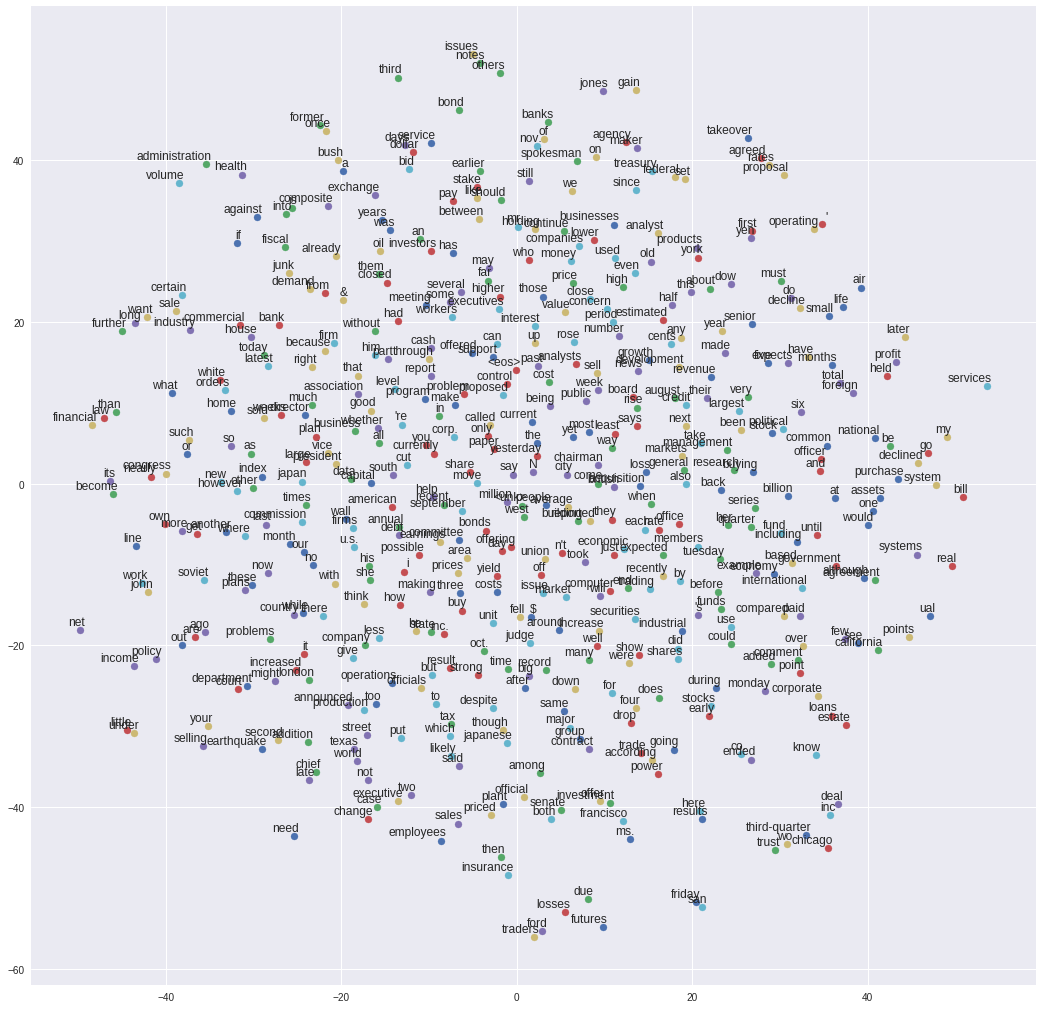

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2,
            init='pca', n_iter=5000, method='exact')
n_embeddings = 500
low_dim_embeddings = tsne.fit_transform(final_embeddings[:n_embeddings, :])
labels = [ptb.id2word[i] for i in range(n_embeddings)]

plot_with_labels(low_dim_embeddings, labels)

##Embeddings and Visualization for text8 dataset

In [49]:
from datasetslib.text8 import Text8
text8 = Text8()
# downloads data, converts words to ids, converts files to a list of ids
text8.load_data()
print('Train:', text8.part['train'][0:5])
print('Vocabulary Length = ', text8.vocab_len)

Already exists: /root/datasets/text8/text8.zip
Train: [5233 3083   11    5  194]
Vocabulary Length =  253854


In [50]:
text8.skip_window = 2
text8.reset_index()
# in CBOW input is the context word and output is the target word
y_batch, x_batch = text8.next_batch_cbow()

print('The CBOW pairs : context,target')
for i in range(5 * text8.skip_window):
    print('(', [text8.id2word[x_i] for x_i in x_batch[i]],
          ',', y_batch[i], text8.id2word[y_batch[i]], ')')

The CBOW pairs : context,target
( ['anarchism', 'originated', 'a', 'term'] , 11 as )
( ['originated', 'as', 'term', 'of'] , 5 a )
( ['as', 'a', 'of', 'abuse'] , 194 term )
( ['a', 'term', 'abuse', 'first'] , 1 of )
( ['term', 'of', 'first', 'used'] , 3133 abuse )
( ['of', 'abuse', 'used', 'against'] , 45 first )
( ['abuse', 'first', 'against', 'early'] , 58 used )
( ['first', 'used', 'early', 'working'] , 155 against )
( ['used', 'against', 'working', 'class'] , 127 early )
( ['against', 'early', 'class', 'radicals'] , 741 working )


In [51]:
text8.skip_window = 2
text8.reset_index()
# in skip-gram input is the target word and output is the context word
x_batch, y_batch = text8.next_batch_sg()

print('The skip-gram pairs : target,context')
for i in range(5 * text8.skip_window):
    print('(', x_batch[i], text8.id2word[x_batch[i]],
          ',', y_batch[i], text8.id2word[y_batch[i]], ')')

The skip-gram pairs : target,context
( 11 as , 5233 anarchism )
( 11 as , 3083 originated )
( 11 as , 5 a )
( 11 as , 194 term )
( 5 a , 3083 originated )
( 5 a , 11 as )
( 5 a , 194 term )
( 5 a , 1 of )
( 194 term , 11 as )
( 194 term , 5 a )


In [52]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [63 48  2 53 60 41 56 68]


In [0]:
batch_size = 128
embedding_size = 128  
n_negative_samples = 64
text8.skip_window=2

In [0]:
tf.reset_default_graph()

In [0]:
inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size])
outputs = tf.placeholder(dtype=tf.int32, shape=[batch_size,1])
inputs_valid = tf.constant(x_valid, dtype=tf.int32)

In [0]:
# define embeddings matrix with vocab_len rows and embedding_size columns
# each row represents vectore representation or embedding of a word in the vocbulary

embed_matrix = tf.Variable(tf.random_uniform(shape=[text8.vocab_len, embedding_size], 
                                           minval = -1.0, 
                                           maxval = 1.0
                                          ),
                           name='embed_matrix'
                        )

# define the embedding lookup table
# provides the embeddings of the word ids in the input tensor
embed_ltable = tf.nn.embedding_lookup(embed_matrix, inputs)

In [0]:
# define noise-contrastive estimation (NCE) loss function

nce_w = tf.Variable(tf.truncated_normal(shape=[text8.vocab_len, embedding_size],
                                        stddev=1.0 / tf.sqrt(embedding_size*1.0)
                                       )
                   )
nce_b = tf.Variable(tf.zeros(shape=[text8.vocab_len]))

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_w,
                                     biases=nce_b,
                                     inputs=embed_ltable,
                                     labels=outputs,
                                     num_sampled=n_negative_samples,
                                     num_classes=text8.vocab_len
                                    )
                     )

In [0]:
# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, keep_dims=True))
normalized_embeddings = embed_matrix / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, inputs_valid)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [59]:
n_epochs = 50
learning_rate = 0.9
text8.reset_index()
n_batches = text8.n_batches_wv()

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as tfs:
    tf.global_variables_initializer().run()

    for epoch in range(n_epochs):
        epoch_loss = 0
        for step in range(n_batches):
            x_batch, y_batch = text8.next_batch_sg()
            y_batch = nputil.to2d(y_batch,unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}

            _, batch_loss = tfs.run([optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
        epoch_loss = epoch_loss / n_batches 

        print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)
        
        # validating at end of every epoch

    
        similarity_scores = tfs.run(similarity)
        for i in range(valid_size):
            top_k = 5
            similar_words = (-similarity_scores[i, :]).argsort()[1:top_k + 1]
            similar_str = 'Similar to {0:}:'.format(text8.id2word[x_valid[i]])
            for k in range(top_k):
                similar_str = '{0:} {1:},'.format(similar_str, text8.id2word[similar_words[k]])
            print(similar_str)
        
    final_embeddings = tfs.run(normalized_embeddings)


Average loss after epoch  0 :  135.63321914158263
Similar to american: this, aldrin, the, maintained, bowl,
Similar to had: mean, alps, gland, australo, rapidly,
Similar to and: in, the, reginae, a, to,
Similar to been: invited, gland, screen, to, wife,
Similar to after: c, test, xm, mkb, ayers,
Similar to but: den, suesca, inch, field, calculation,
Similar to who: gland, oldest, gabor, sounds, comparison,
Similar to may: caesium, course, frost, recoil, export,

Average loss after epoch  1 :  70.48734899710598
Similar to american: this, from, conventional, advances, bowl,
Similar to had: blonde, mean, alps, has, annus,
Similar to and: in, of, the, with, for,
Similar to been: gland, psi, coding, invited, user,
Similar to after: agincourt, helicopters, even, phi, andaman,
Similar to but: den, was, and, field, that,
Similar to who: gathered, which, gland, oldest, coke,
Similar to may: bckgr, ngc, psi, guitar, azerbaijan,

Average loss after epoch  2 :  49.046921470582454
Similar to ameri

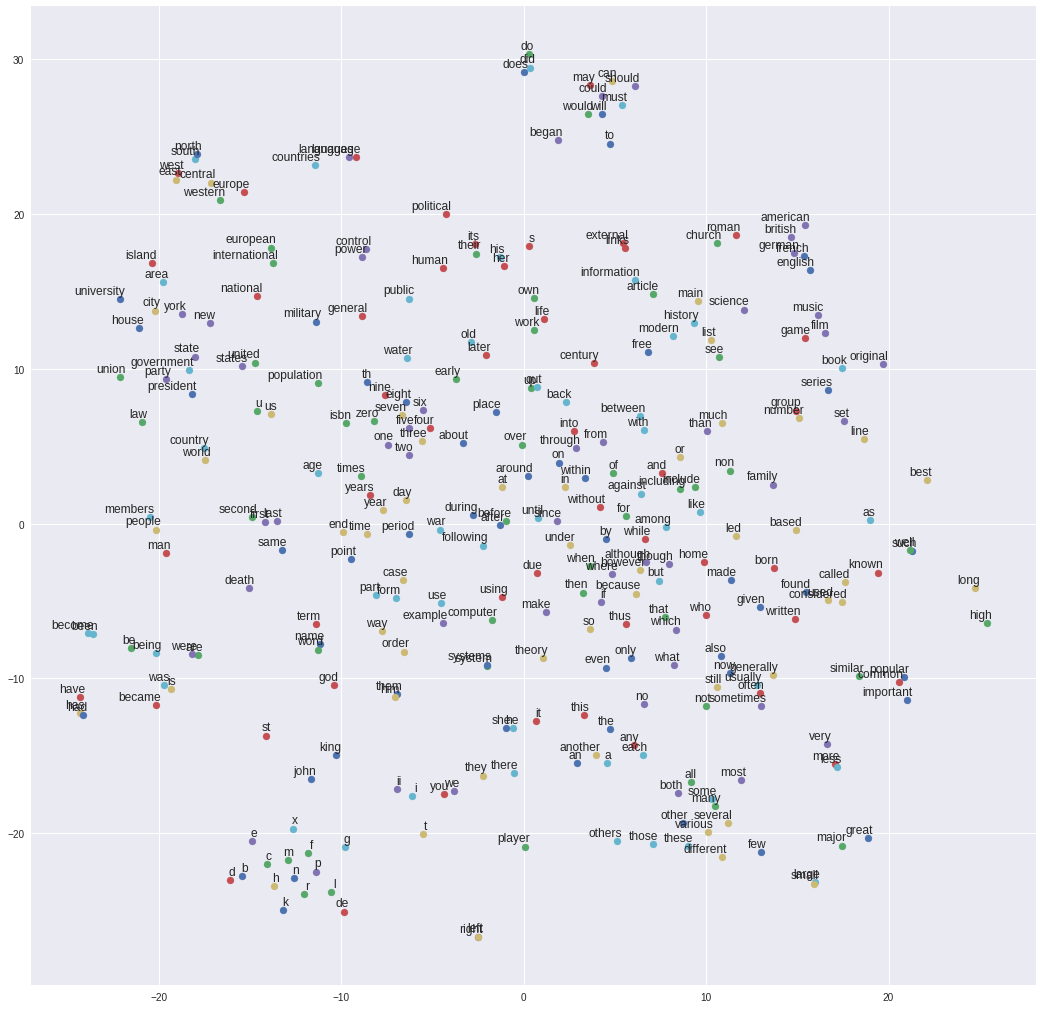

In [60]:
def plot_with_words(low_dim_embeddings, words):
  assert low_dim_embeddings.shape[0] >= len(words), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, words in enumerate(words):
    x, y = low_dim_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(words,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
  plt.show()


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
n_embeddings = 300
low_dim_embeddings = tsne.fit_transform(final_embeddings[:n_embeddings, :])
words = [text8.id2word[i] for i in range(n_embeddings)]
  
plot_with_words(low_dim_embeddings, words)

#skip-gram model with Keras

In [61]:
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Input, Dense, Reshape, Dot, merge
import keras

Using TensorFlow backend.


In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

Create a validation set that we will use to print the similar words that our model
found at the end of the training:

In [63]:
valid_size = 8
x_valid = np.random.choice(valid_size * 10, valid_size, replace=False)
print('valid: ',x_valid)

valid:  [62 13  8 45 52 66 70 34]


In [0]:
embedding_size = 512  
n_negative_samples = 64
ptb.skip_window=2

Use the `make_sampling_table()` function from
`keras.preprocessing.sequence` to create a sample table of the size equal to
the length of our vocabulary. Next, use the function `skipgrams()`
from `keras.preprocessing.sequence` to generate the pairs of context and
target words along with the labels representing if they are true or fake pairs.

In [0]:
sample_table = sequence.make_sampling_table(ptb.vocab_len)
pairs, labels= sequence.skipgrams(ptb.part['train'],
                        ptb.vocab_len,
                        window_size=ptb.skip_window,
                        sampling_table=sample_table)

print some of the fake and true pairs that are generated with the following
code:

In [66]:
print('The skip-gram pairs : target,context')
for i in range(5 * ptb.skip_window):
    print(['{} {}'.format(id,ptb.id2word[id]) for id in pairs[i]],':',labels[i])

The skip-gram pairs : target,context
['4 of', '9575 x'] : 0
['8646 barron', '3544 terrorism'] : 0
['207 debt', '8665 blind'] : 0
['4 of', '19 as'] : 1
['7338 constituency', '2 <eos>'] : 1
['3603 injuries', '4555 respect'] : 0
['241 high', '7856 apt'] : 0
['1001 france', '124 under'] : 1
['8513 vacated', '4262 displays'] : 0
['1613 launched', '2851 eased'] : 0


Split the target and context words from the pairs generated above so they can be
fed to the model. Convert the target and context words to two-dimensional
arrays.

In [0]:
x,y=zip(*pairs)
x=np.array(x,dtype=np.int32)
x=nputil.to2d(x,unit_axis=1)
y=np.array(y,dtype=np.int32)
y=nputil.to2d(y,unit_axis=1)
labels=np.array(labels,dtype=np.int32)
labels=nputil.to2d(labels,unit_axis=1)

Define the architecture of the network. As we discussed, the target and context
words have to be fed into the network and their vectors need to be looked up
from the embedding layers. Thus, first we define the input, embedding, and
reshape layers for the target and context words respectively:

In [0]:
# build the target word model
target_in = Input(shape=(1,),name='target_in')
target = Embedding(ptb.vocab_len,embedding_size,input_length=1,name='target_em')(target_in)
target = Reshape((embedding_size,1),name='target_re')(target)

# build the context word model
context_in = Input((1,),name='context_in')
context = Embedding(ptb.vocab_len,embedding_size,input_length=1,name='context_em')(context_in)
context = Reshape((embedding_size,1),name='context_re')(context)

Next, build the dot product of these two models, which feeds into the sigmoid
layer to generate the output labels:

In [0]:
# merge the models with the dot product to check for similarity and add sigmoid layer
output = Dot(axes=1,name='output_dot')([target,context])
output = Reshape((1,),name='output_re')(output)
output = Dense(1,activation='sigmoid',name='output_sig')(output)


Build the functional model from the input and output models

In [0]:
# create the functional model for finding word vectors
model = Model(inputs=[target_in,context_in],outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam')

Additionally, build a model that will be used to predict the similarity to all the
words, given the input target word:

In [71]:
# merge the models and create model to check for cosine similarity
similarity = Dot(axes=0,normalize=True,name='sim_dot')([target,context])
similarity_model = Model(inputs=[target_in,context_in],outputs=similarity)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_in (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
context_in (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
target_em (Embedding)           (None, 1, 512)       5120000     target_in[0][0]                  
__________________________________________________________________________________________________
context_em (Embedding)          (None, 1, 512)       5120000     context_in[0][0]                 
__________________________________________________________________________________________________
target_re 

Next, train the model for 5 epochs,

In [72]:
# train the model
n_epochs = 5
batch_size = 1024
model.fit([x,y],labels,batch_size=batch_size, epochs=n_epochs)

Epoch 1/5
1096366/1096366 [==============================] - 156s 143us/step - loss: 0.4523
Epoch 2/5
1096366/1096366 [==============================] - 155s 141us/step - loss: 0.2711
Epoch 3/5
1096366/1096366 [==============================] - 155s 141us/step - loss: 0.0887
Epoch 4/5
1096366/1096366 [==============================] - 154s 141us/step - loss: 0.0263
Epoch 5/5
1096366/1096366 [==============================] - 156s 142us/step - loss: 0.0212


Print the similarity of the words based on the word vectors discovered by this model:

In [73]:
# print closest words to validation set at end of training
top_k = 5  
y_val = np.arange(ptb.vocab_len, dtype=np.int32)
y_val = nputil.to2d(y_val,unit_axis=1)
for i in range(valid_size):
    x_val = np.full(shape=(ptb.vocab_len,1),fill_value=x_valid[i], dtype=np.int32)
    similarity_scores = similarity_model.predict([x_val,y_val])
    similarity_scores=similarity_scores.flatten()
    similar_words = (-similarity_scores).argsort()[1:top_k + 1]
    similar_str = 'Similar to {0:}:'.format(ptb.id2word[x_valid[i]])
    for k in range(top_k):
        similar_str = '{0:} {1:},'.format(similar_str, ptb.id2word[similar_words[k]])
    print(similar_str)

Similar to share: cents, million, year, of, N,
Similar to is: has, we, there, up, said,
Similar to and: we, an, executive, labor, country,
Similar to more: N, $, new, a, on,
Similar to up: N, year, its, <unk>, for,
Similar to if: more, mr., they, 'd, no,
Similar to president: chief, senior, of, former, an,
Similar to have: should, that, was, we, to,


#word2vec or embedding visualization using TensorBoard

##Initialize the TensorBoard in Colab

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
      'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format(LOG_DIR))

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

##TensorBoard visualization

In [0]:
tf.reset_default_graph()

In [0]:
from tensorflow.contrib.tensorboard.plugins import projector

batch_size = 128
embedding_size = 128  
n_negative_samples = 64
ptb.skip_window=2

inputs = tf.placeholder(dtype=tf.int32, shape=[batch_size],name='inputs')
outputs = tf.placeholder(dtype=tf.int32, shape=[batch_size,1],name='outputs')
inputs_valid = tf.constant(x_valid, dtype=tf.int32,name='inputs_valid')

# define embeddings matrix with vocab_len rows and embedding_size columns
# each row represents vectore representation or embedding of a word in the vocbulary

embed_matrix = tf.Variable(tf.random_uniform(shape=[ptb.vocab_len, embedding_size], 
                                           minval = -1.0, 
                                           maxval = 1.0
                                          ),
                           name='embed_matrix'
                        )
# define the embedding lookup table
# provides the embeddings of the word ids in the input tensor
embed_ltable = tf.nn.embedding_lookup(embed_matrix, inputs)

# define noise-contrastive estimation (NCE) loss layer

nce_w = tf.Variable(tf.truncated_normal(shape=[ptb.vocab_len, embedding_size],
                                        stddev=1.0 / tf.sqrt(embedding_size*1.0)
                                       ),
                    name='nce_w'
                   )
nce_b = tf.Variable(tf.zeros(shape=[ptb.vocab_len]), name='nce_b')

loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_w,
                                     biases=nce_b,
                                     inputs=embed_ltable,
                                     labels=outputs,
                                     num_sampled=n_negative_samples,
                                     num_classes=ptb.vocab_len
                                    ),
                      name='nce_loss'
                     )

# Compute the cosine similarity between validation set samples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, keep_dims=True),name='norm')
normalized_embeddings = tf.divide(embed_matrix,norm,name='normalized_embeddings')
embed_valid = tf.nn.embedding_lookup(normalized_embeddings, inputs_valid)
similarity = tf.matmul(embed_valid, normalized_embeddings, transpose_b=True, name='similarity')

n_epochs = 10
learning_rate = 0.9

n_batches = ptb.n_batches_wv()

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

log_dir = 'logs'

# save the vocabulary
vocabfile = 'word2id.tsv'
ptb.save_word2id(os.path.join(log_dir, vocabfile))

# create summary variable
tf.summary.scalar('epoch_loss_scalar',epoch_loss)
tf.summary.histogram('epoch_loss_histogram',epoch_loss)

merged = tf.summary.merge_all()

with tf.Session() as tfs:

    saver = tf.train.Saver()
    
    # Declare projector config
    config=projector.ProjectorConfig()

    # add embedding variable to the config
    embed_conf1 = config.embeddings.add()
    embed_conf1.tensor_name = embed_matrix.name
    embed_conf1.metadata_path = vocabfile
    
    
    file_writer = tf.summary.FileWriter(log_dir,tfs.graph)

    # save embeddings config that TensorBoard will read and visualize
    projector.visualize_embeddings(file_writer,config)
    
    tf.global_variables_initializer().run()

    for epoch in range(n_epochs):
        epoch_loss = 0
        ptb.reset_index()
        for step in range(n_batches):
            x_batch, y_batch = ptb.next_batch_sg()
            y_batch = nputil.to2d(y_batch,unit_axis=1)
            feed_dict = {inputs: x_batch, outputs: y_batch}
            summary, _, batch_loss = tfs.run([merged, optimizer, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
            saver.save(tfs, 
                       os.path.join(log_dir, 'model.ckpt'), 
                       global_step = epoch * n_batches + step)
        epoch_loss = epoch_loss / n_batches
        file_writer.add_summary(summary,global_step = epoch * n_batches + step)

        print('\nAverage loss after epoch ', epoch, ': ', epoch_loss)
        
        # print closest words to validation set at end of every epoch

        similarity_scores = tfs.run(similarity)
        top_k = 5  
        for i in range(valid_size):
            similar_words = (-similarity_scores[i, :]).argsort()[1:top_k + 1]
            similar_str = 'Similar to {0:}:'.format(ptb.id2word[x_valid[i]])
            for k in range(top_k):
                similar_str = '{0:} {1:},'.format(similar_str, ptb.id2word[similar_words[k]])
            print(similar_str)
        
    final_embeddings = tfs.run(normalized_embeddings)

##word2id and id2word explaination

In [0]:
import collections
counter=collections.Counter(['a','b','a','c','a','c'])
l=lambda x: (-x[1],x[0])
count_pairs=sorted(counter.items(),key=l)
words,_=list(zip(*count_pairs))
print('words: ', words)

word2id = dict(zip(words, range(len(words))))
print('word2id: ', word2id)
id2word = dict(zip(word2id.values(), word2id.keys()))
print('id2owrd: ', id2word)

#Text generation with RNN mdoels in TensoFlow and Keras
load the text8 dataset

In [74]:
from datasetslib.text8 import Text8
text8 = Text8()
text8.load_data(clip_at=5000) # downloads data, converts words to ids, converts files to a list of ids
print('Train:', text8.part['train'][0:5])
print('Vocabulary Length = ',text8.vocab_len)

Already exists: /root/datasets/text8/text8.zip
Train: [  8 497   7   5 116]
Vocabulary Length =  1457


In [75]:
def id2string(ids):
    return ' '.join([text8.id2word[x_i] for x_i in ids])
print(id2string(text8.part['train'][0:100]))

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing


In [76]:
# parameters

n_x = 5 # number of input words
n_y = 1 # number of output words
n_x_vars = 1 # in case of our text, there is only 1 variable at each timestep
n_y_vars = text8.vocab_len

random5 = np.random.choice(n_x * 50, n_x, replace=False)
print('Random 5 words: ',id2string(random5))
first5 = text8.part['train'][0:n_x].copy()
print('First 5 words: ',id2string(first5))

Random 5 words:  society eight tolstoy modern advocates
First 5 words:  anarchism originated as a term


##Text generation LSTM in TensorFlow

In [0]:
tf.reset_default_graph()

define the parameters and placeholders

In [0]:
# parameters

batch_size = 128
n_x = 5 # number of input words
n_y = 1 # number of output words
n_x_vars = 1 # in case of our text, there is only 1 variable at each timestep
n_y_vars = text8.vocab_len
state_size = 128
learning_rate = 0.001

x_p = tf.placeholder(tf.float32, [None, n_x, n_x_vars], name='x_p') 
y_p = tf.placeholder(tf.float32, [None, n_y_vars], name='y_p')

For input, we are using the integer representations of the words, hence `n_x_vars` is 1. For
output we are using one-hot encoded values hence the number of outputs is equal to the
vocabulary length.

Next, create a list of tensors of length `n_x`

In [0]:
# make a list of tensors of length n_x
x_in = tf.unstack(x_p,axis=1,name='x_in')

# can also be done using this: 
# reshape x placeholder to [1, n_timesteps]
# x = tf.reshape(x_p,[-1,n_x])
# generate sequence of inputs, each input is n_timesteps long
# x = tf.split(x,n_x,1,name='x')

Next, create an LSTM cell and a static RNN network from the inputs and the cell:

In [0]:
cell = tf.nn.rnn_cell.LSTMCell(state_size)
rnn_outputs, final_states = tf.nn.static_rnn(cell, x_in,dtype=tf.float32)

Next, we define the weight, biases, and formulae for the final layer. The final
layer only needs to pick the output for the sixth word

In [81]:
random5 = np.random.choice(n_x * 50, n_x, replace=False)
print('Random 5 words: ',id2string(random5))
first5 = text8.part['train'][0:n_x].copy()
print('First 5 words: ',id2string(first5))

# pick the last output only

# output node parameters
w = tf.get_variable('w', [state_size, n_y_vars], initializer= tf.random_normal_initializer)
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

y_out = tf.matmul(rnn_outputs[-1], w) + b

Random 5 words:  use conflict amongst have benjamin
First 5 words:  anarchism originated as a term


Next, create a loss function and optimizer, and accuracy function:

In [82]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_out, labels=y_p))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

n_correct_pred = tf.equal(tf.argmax(y_out,1), tf.argmax(y_p,1))
accuracy = tf.reduce_mean(tf.cast(n_correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Train the model for 1,000 epochs and print the results every 100
epochs.

In [83]:
n_epochs = 1000
learning_rate = 0.001
text8.reset_index()
n_batches = text8.n_batches_seq(n_tx=n_x,n_ty=n_y)
n_epochs_display = 100

with tf.Session() as tfs:
    tf.global_variables_initializer().run()

    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for step in range(n_batches):
            x_batch, y_batch = text8.next_batch_seq(n_tx=n_x,n_ty=n_y)
            y_batch = nputil.to2d(y_batch,unit_axis=1)
            y_onehot = np.zeros(shape=[batch_size,text8.vocab_len],dtype=np.float32)
            for i in range(batch_size):
                y_onehot[i,y_batch[i]]=1
            
            feed_dict = {x_p: x_batch.reshape(-1, n_x, n_x_vars), y_p: y_onehot}

            _, batch_accuracy, batch_loss = tfs.run([optimizer, accuracy, loss], feed_dict=feed_dict)
            epoch_loss += batch_loss
            epoch_accuracy += batch_accuracy
        if (epoch+1) % (n_epochs_display) == 0:
            epoch_loss = epoch_loss / n_batches
            epoch_accuracy = epoch_accuracy / n_batches
            print('\nEpoch {0:}, Average loss:{1:}, Average accuracy:{2:}'.
              format(epoch,epoch_loss,epoch_accuracy ))
            
            y_pred_r5 = np.empty([10])
            y_pred_f5 = np.empty([10])
            
            x_test_r5 = random5.copy()
            x_test_f5 = first5.copy()
            # let us generate text of 20 words after feeding 5 words
            for i in range(10):
                for x,y in zip([x_test_r5,x_test_f5],[y_pred_r5,y_pred_f5]):
                    x_input = x.copy()
                    feed_dict = {x_p: x_input.reshape(-1, n_x, n_x_vars)}
                    y_pred = tfs.run(y_out, feed_dict=feed_dict)
                    y_pred_id = int(tf.argmax(y_pred, 1).eval())
                    y[i]=y_pred_id
                    x[:-1] = x[1:]
                    x[-1] = y_pred_id
            print('  Random 5 prediction:',id2string(y_pred_r5))
            print('  First 5 prediction:',id2string(y_pred_f5))


Epoch 99, Average loss:1.4486463765303295, Average accuracy:0.830078125
  Random 5 prediction: new without without without through through through harmony harmony harmony
  First 5 prediction: market benjamin market system william without without without without through

Epoch 199, Average loss:0.7471852799256643, Average accuracy:0.9029947916666666
  Random 5 prediction: propaganda anarcho with anarcho zero zero s s zero s
  First 5 prediction: international revolution contemporary propaganda anarcho it anarcho zero zero s

Epoch 299, Average loss:1.3472486436367035, Average accuracy:0.8541666666666666
  Random 5 prediction: can chinese certain author author author anabaptist anarchistic anarchistic anarchistic
  First 5 prediction: religious europe europe than than action action authoritarian authoritarian authoritarian

Epoch 399, Average loss:1.3355932732423146, Average accuracy:0.8528645833333334
  Random 5 prediction: force left groups groups anarchy anarchy post post post post


##Text generation LSTM in Keras

First, convert all of the data into two tensors, tensor x with five columns since
we input five words at a time, and tensor y with just one column of output. We
convert the y or label tensor into one-hot encoded representation.

In [84]:
from datasetslib.text8 import Text8
text8 = Text8()
text8.load_data(clip_at=5000) # downloads data, converts words to ids, converts files to a list of ids
print('Train:', text8.part['train'][0:5])
#print(text8.part['test'][0:5])
#print(text8.part['valid'][0:5])
print('Vocabulary Length = ',text8.vocab_len)

Already exists: /root/datasets/text8/text8.zip
Train: [  8 497   7   5 116]
Vocabulary Length =  1457


In [85]:
def id2string(ids):
    return ' '.join([text8.id2word[x_i] for x_i in ids])
print(id2string(text8.part['train'][0:100]))

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing


In [86]:
# parameters

n_x = 5 # number of input words
n_y = 1 # number of output words
n_x_vars = 1 # in case of our text, there is only 1 variable at each timestep
n_y_vars = text8.vocab_len

random5 = np.random.choice(n_x * 50, n_x, replace=False)
print('Random 5 words: ',id2string(random5))
first5 = text8.part['train'][0:n_x].copy()
print('First 5 words: ',id2string(first5))

Random 5 words:  all cgt violent authority century
First 5 words:  anarchism originated as a term


In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
# get the data
x_train, y_train = text8.seq_to_xy(seq=text8.part['train'],n_tx=n_x,n_ty=n_y)

# reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
#x_test = x_test.reshape(x_test.shape[0], X_train.shape[1], 1)
y_onehot = np.zeros(shape=[y_train.shape[0],text8.vocab_len],dtype=np.float32)
for i in range(y_train.shape[0]):
    y_onehot[i,y_train[i]]=1

Next, define the LSTM model with only one hidden LSTM Layer. Since our
output is not a sequence, we also set the return_sequences to False:

In [93]:
# parameters
n_epochs = 1000
batch_size=128
state_size=128
n_epochs_display=100
            
# create and fit the LSTM model
model = Sequential()
model.add(LSTM(units=state_size, 
               input_shape=(x_train.shape[1], x_train.shape[2]),
               return_sequences=False
              )
         )
model.add(Dense(text8.vocab_len))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 1457)              187953    
_________________________________________________________________
activation_1 (Activation)    (None, 1457)              0         
Total params: 254,513
Trainable params: 254,513
Non-trainable params: 0
_________________________________________________________________


Run a loop to run the 10 times, within each iteration train the model
for 100 epochs and print the results of text generation.

In [94]:
#random5 = np.random.choice(n_x * 100, n_x, replace=False)
print('Random 5 words: ',id2string(random5))
#first5 = text8.part['train'][0:n_x].copy()
print('First 5 words: ',id2string(first5))

print('\nLet\'s train and predict now:\n')

Random 5 words:  all cgt violent authority century
First 5 words:  anarchism originated as a term

Let's train and predict now:



In [0]:
for j in range(n_epochs // n_epochs_display):
    model.fit(x_train, y_onehot, epochs=n_epochs_display, batch_size=batch_size,verbose=0)

    # generate text
    y_pred_r5 = np.empty([10])
    y_pred_f5 = np.empty([10])

    x_test_r5 = random5.copy()
    x_test_f5 = first5.copy()
    # let us generate text of 10 words after feeding 5 words
    for i in range(10):
        for x,y in zip([x_test_r5,x_test_f5],[y_pred_r5,y_pred_f5]):
            x_input = x.copy()
            x_input = x_input.reshape(-1, n_x, n_x_vars)
            y_pred = model.predict(x_input)[0]
            y_pred_id = np.argmax(y_pred)
            y[i]=y_pred_id
            x[:-1] = x[1:]
            x[-1] = y_pred_id
    print('Epoch: ',((j+1) * n_epochs_display)-1)
    print('  Random5 prediction:',id2string(y_pred_r5))
    print('  First5 prediction:',id2string(y_pred_f5))

Epoch:  99
  Random5 prediction: warren warren warren warren warren warren warren warren warren warren
  First5 prediction: self i philosophy communism both both both both both both
Epoch:  199
  Random5 prediction: warren should had had had had had had had had
  First5 prediction: term i philosophy than than than than than than than
Epoch:  299
  Random5 prediction: goldman however published published published published published published published published
  First5 prediction: term i philosophy than than than than than than than
Epoch:  399
  Random5 prediction: warren should had had had had had had had had
  First5 prediction: term i philosophy than than than than than than than
Epoch:  499
  Random5 prediction: warren should had had had had had had had had
  First5 prediction: term i class than than than than than than than
Epoch:  599
  Random5 prediction: warren warren had had had had had had had had
  First5 prediction: term i class than than than than than than than
